In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os, time, copy
# import matplotlib
# matplotlib.use('TkAgg')

os.environ['TZ'] = 'Asia/Ho_Chi_Minh' # set new timezone
time.tzset()

In [2]:
# # load csv that contain groundtruth
# import pandas as pd
# df = pd.read_csv('/home/dev1/Downloads/UHCTD Comprehensive Dataset For Camera Tampering Detection/Camera B/Testing video/Day 3/annotations.csv')
# df.head()

In [3]:
# df.loc[df['is tampered'] == 2]  # find tamper in csv file: 1: covered, 2: blur, 3: moved

### Config

In [4]:
cap = cv2.VideoCapture('vtest.avi')  # put your video here
fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
fgbg.setNMixtures(4)
fgbg.setVarInit(100)
# print(fgbg.getNMixtures())

# watch activities from start_frame to end_frame
start_frame, end_frame = 0, np.inf
assert start_frame < end_frame, 'start_frame must be smaller than end_frame'

# config
learning_rate = 0.002  # gamma
t_init = 600    # T init
t_fix = 600     # T fix
t_set = 3     # T set
w = 700   # size of the tamper validation window (length)   (w > t_fix)
assert w > t_fix, 'w must be larger than t_fix'

frame_no = 0
tamper_flag = 0 # f_{n}^{t}
tamper_flag_count = 0   # count++ if tamper_flag=1
tamper_validation_count = 0 # S
fixed_tamper_flag = False   # set by hand, turn off by hand

In [5]:
def sobel_edge_detection(image_gray, blur_ksize=7, sobel_ksize=1, skipping_threshold=10):
    """

    Input:
    ---
        image_gray: already read by opencv
        blur_ksize: kernel size parameter for Gaussian Blurry
        sobel_ksize: size of the extended Sobel kernel; it must be 1, 3, 5, or 7.
        skipping_threshold: ignore weakly edge

    Output:
    ---
        Edge matrix ∈ {0, 255}
    """
    img_gaussian = cv2.GaussianBlur(image_gray, (blur_ksize, blur_ksize), 0)
    
    # sobel algorthm use cv2.CV_64F
    sobelx64f = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    abs_sobelx64f = np.absolute(sobelx64f)
    img_sobelx = np.uint8(abs_sobelx64f)

    sobely64f = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=sobel_ksize)
    abs_sobely64f = np.absolute(sobely64f)
    img_sobely = np.uint8(abs_sobely64f)
    
    # calculate magnitude
    img_sobel = (img_sobelx + img_sobely) / 2
    
    # ignore weakly pixel
    img_sobel[img_sobel < skipping_threshold] = 0
    img_sobel[img_sobel >= skipping_threshold] = 255
    return np.array(img_sobel, dtype=np.uint8)

def calculate_th(e_bg):
    '''

    Input:
    ---
        e_bg: #edge pixel in the n-th background frame

    Output:
    ---
        Adaptive threshold (All the values used in paper)
    '''
    h, w = e_bg.shape[0], e_bg.shape[1]
    e_bg = np.sum(e_bg) / 255
    # print(e_bg/(w*h))
    if e_bg / (w * h) < 0.026 * 2:
        return 150 / e_bg
    elif 0.026*2 <= e_bg / (w * h) < 0.046 * 2:
        return 400 / e_bg
    else:
        return 1500 / e_bg

def calculate_tamper_validation_count(tamper_validation_count, w, edr, aedr, th):
    '''
    To prevent wrong false alarms due to noise or temporary scene characteristic change\n
    
    Input:
    ---
        w: Size of the tamper validation window
        edr: Edge disappearance rate
        aedr: Average edge disappearance rate
        th: Adaptive threshold
    
    Output:
    ---
        tamper_validation_count
    '''
    if edr > aedr + th:
        return min(tamper_validation_count + 1, w)
    return max(tamper_validation_count - 1, 0)

aedr = 0

# store list for plot
aedr_list = []
edr_list = []
aedr_th_list = []
th_list = []
edr_sum = 0     # sum(edr) if no tamper attack

bg_temp = None  # to save temp background

# # for eval    (turn on these line for eval)
# tp = 0  # alert for tamper attack
# tn = 0  # no alert for no tamper attack
# fn = 0  # no alert for a tamper attack
# fp = 0  # alert for no tamper attack

while True:
    frame_no += 1  
    notification = 'None'

    ret, frame = cap.read()
    # print('frame number: {}'.format(frame_no))
    if ret is False:
        break

    if frame_no > start_frame:
        frame = cv2.resize(frame, (320, 240))
        cv2.imshow('frame_rgb', frame)
        cv2.moveWindow('frame_rgb', 500, 50)
        fgmask = fgbg.apply(frame, learningRate = learning_rate)
        # fgmask = cv2.medianBlur(fgmask, 3)
        # fgmask = cv2.erode(fgmask, np.ones((1,1)))
        fgmask = cv2.dilate(fgmask, np.ones((5, 5)))    # we can replace np.ones((..., ...)) by np.array(rotate(np.ones((9,9)), angle=45, reshape=False), dtype=np.uint8)  
                                                    # cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
        
        if tamper_flag == 1:    # if tamper attack occur:
            bg = bg_temp    # save background before attack for compare edge
        else:                   # if tamper attack not happen
            bg = fgbg.getBackgroundImage()
            bg_temp = bg    # save background to bg_temp
        
        # bg = fgbg.getBackgroundImage()

        cv2.imshow('fgmask', fgmask)
        cv2.moveWindow('fgmask', 900, 225)

        cv2.imshow('bg', bg)
        cv2.moveWindow('bg', 100, 50)

        # serve for edr
        background_gray = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if frame_no > start_frame + 1:  # not calculate anything in first frame
            mask_to_exclude = (fgmask == 255)
            # # auto canny
            # sigma = 0.1
            # median = np.median(background_gray)
            # lower = int(max(0, (1.-sigma)*median))
            # upper = int(min(255, (1.+sigma)*median))
            e_bg = sobel_edge_detection(background_gray)    #cv2.Canny(background_gray, 290, 300)
            cv2.imshow('bg_sobel', e_bg)
            cv2.moveWindow('bg_sobel', 100, 400)
            e_c = sobel_edge_detection(frame_gray)  #cv2.Canny(frame_gray, 290, 300)
            cv2.imshow('c_sobel', e_c)
            cv2.moveWindow('c_sobel', 500, 400)

            # th
            th = calculate_th(e_bg)

            # calculate edr
            e_bg[mask_to_exclude] = 0
            e_c[mask_to_exclude] = 0
            edr = 1 - (np.sum(e_bg & e_c)) / (np.sum(e_bg) + 1)     # +1 avoid 0/0
            
            # aedr
            if tamper_flag == 0: # If any tamper attack occurs, the AEDR keeps the current value
                edr_sum += edr
                aedr = np.sum((1 - tamper_flag) * edr_sum) / (frame_no - tamper_flag_count)

            if frame_no > t_init + start_frame:    # generating background before monitoring
                # tamper validation count:
                tamper_validation_count = calculate_tamper_validation_count(tamper_validation_count, w, edr, aedr, th)

                # tamper flag setting:
                tamper_flag = 1 if tamper_validation_count > t_set else 0

                tamper_flag_count += tamper_flag

                if tamper_validation_count > t_fix:
                    notification = 'Tamper attacked'
                    fixed_tamper_flag = True

            print('{:s} | frame no: {:d} \t edr: {:.4f} \t aedr: {:.4f} \t th: {:.4f} \t is tamper flag: {:d} \t tamper validation count: {:d} \t status: {:s}'
            .format(time.strftime('%Y-%m-%d %H:%M:%S'), frame_no, edr, aedr, th, tamper_flag, tamper_validation_count, notification))

            aedr_list.append(aedr)
            edr_list.append(edr)
            aedr_th_list.append(aedr + th)
            th_list.append(th)

            # # eval    (turn on these lines for eval)
            # gt, pr = df.iloc[frame_no]['is tampered'], tamper_flag  # ground truth, predict
            # tp += np.sum(np.logical_and(gt, pr))
            # tn += np.sum(np.logical_not(np.logical_or(gt, pr)))
            # fn += np.sum(np.logical_and(gt, np.logical_xor(gt, pr)))
            # fp += np.sum(np.logical_and(pr, np.logical_xor(gt, pr)))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
    if frame_no == end_frame:
        break

cap.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x24785a0) is not the object's thread (0x2acbae0).
Cannot move to target thread (0x24785a0)

QObject::moveToThread: Current thread (0x24785a0) is not the object's thread (0x2acbae0).
Cannot move to target thread (0x24785a0)

QObject::moveToThread: Current thread (0x24785a0) is not the object's thread (0x2acbae0).
Cannot move to target thread (0x24785a0)

QObject::moveToThread: Current thread (0x24785a0) is not the object's thread (0x2acbae0).
Cannot move to target thread (0x24785a0)

QObject::moveToThread: Current thread (0x24785a0) is not the object's thread (0x2acbae0).
Cannot move to target thread (0x24785a0)

QObject::moveToThread: Current thread (0x24785a0) is not the object's thread (0x2acbae0).
Cannot move to target thread (0x24785a0)

QObject::moveToThread: Current thread (0x24785a0) is not the object's thread (0x2acbae0).
Cannot move to target thread (0x24785a0)

QObject::moveToThread: Current thread (0x24785a0) is not the object's thread

2023-04-14 00:51:18 | frame no: 2 	 edr: 0.0201 	 aedr: 0.0101 	 th: 0.1196 	 is tamper flag: 0 	 tamper validation count: 0 	 status: None
2023-04-14 00:51:18 | frame no: 3 	 edr: 0.0224 	 aedr: 0.0142 	 th: 0.1196 	 is tamper flag: 0 	 tamper validation count: 0 	 status: None
2023-04-14 00:51:18 | frame no: 4 	 edr: 0.0222 	 aedr: 0.0162 	 th: 0.1196 	 is tamper flag: 0 	 tamper validation count: 0 	 status: None
2023-04-14 00:51:18 | frame no: 5 	 edr: 0.0230 	 aedr: 0.0175 	 th: 0.1196 	 is tamper flag: 0 	 tamper validation count: 0 	 status: None
2023-04-14 00:51:18 | frame no: 6 	 edr: 0.0228 	 aedr: 0.0184 	 th: 0.1196 	 is tamper flag: 0 	 tamper validation count: 0 	 status: None
2023-04-14 00:51:18 | frame no: 7 	 edr: 0.0232 	 aedr: 0.0191 	 th: 0.1196 	 is tamper flag: 0 	 tamper validation count: 0 	 status: None
2023-04-14 00:51:18 | frame no: 8 	 edr: 0.0227 	 aedr: 0.0195 	 th: 0.1196 	 is tamper flag: 0 	 tamper validation count: 0 	 status: None
2023-04-14 00:51:18 

In [6]:
# # eval    (turn on these code for eval)
# print('detection rate: {:.2f}'.format(tp/(tp+fn)))
# print('precision rate: {:.2f}'.format(tp/(tp+fp)))
# print('daily false alarm rate: {:.2f}'.format(fp/frame_no))

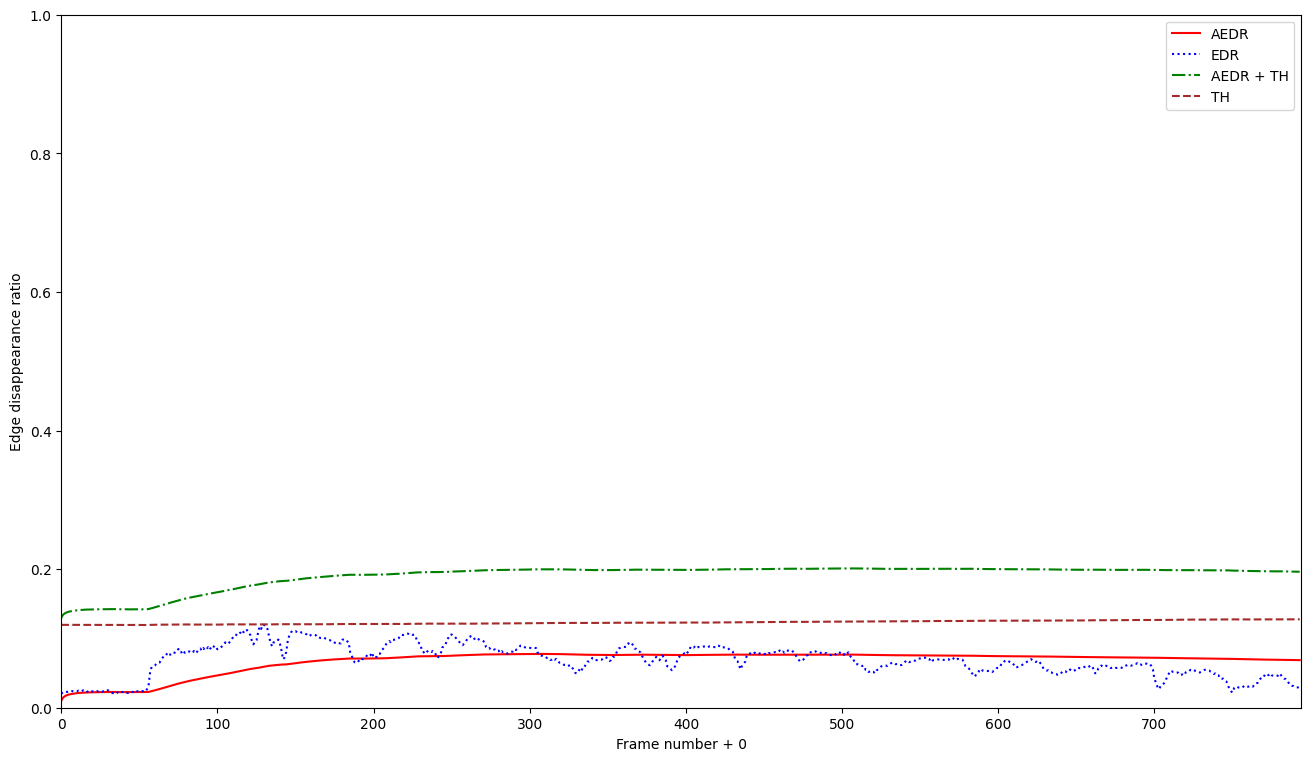

In [7]:
# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.plot(aedr_list, 'r', label='AEDR')
plt.plot(edr_list, 'b', linestyle = ':', label='EDR')
plt.plot(aedr_th_list, 'g', linestyle = '-.', label='AEDR + TH')
plt.plot(th_list, 'brown', linestyle = '--', label='TH')
plt.ylim([0, 1])
plt.xlim([0, len(th_list)])
plt.xlabel('Frame number + {:d}'.format(start_frame))
plt.ylabel('Edge disappearance ratio')
plt.legend()
# Display
plt.show()